In [1]:
%pylab inline
import os
import keras
import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec

from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score

# run the code under DEC-keras
## git clone https://github.com/XifengGuo/DEC-keras
## cd DEC-keras

# download the data from: https://datahack.analyticsvidhya.com/contest/practice-problem-identify-the-digits/

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
seed = 410  # I miss him, miss him so much
rng = np.random.RandomState(seed)

In [7]:
root_dir = os.path.abspath('.')
data_dir = os.path.join(root_dir, 'data', 'minist')

In [8]:
# I moved the downloaded data into /minist
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


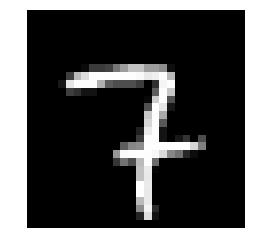

In [16]:
# randomly chose the digit to print out
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [19]:
# store the images into numpy array
def image2array(image_folder_path, filename_lst):
    temp = []
    for img_name in filename_lst.filename:
        image_path = os.path.join(image_folder_path, img_name)
        img = imread(image_path, flatten=True)
        img = img.astype('float32')
        temp.append(img)

    data_x = np.stack(temp)

    data_x /= 255.0
    data_x = data_x.reshape(-1, 784).astype('float32')
    
    return data_x

train_x = image2array(os.path.join(data_dir, 'train'), train)
test_x = image2array(os.path.join(data_dir, 'test'), test)

In [26]:
test_x[4:10]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [27]:
train_y = train.label.values
train_y[4:10]

array([3, 9, 4, 9, 3, 4])

In [28]:
# divide the training data into training and validation
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_y[:split_size], train_y[split_size:]

In [30]:
# Model 1 - Just use kmeans
km = KMeans(n_jobs=-1, n_clusters=10, n_init=20, random_state=410)  # n_init is the number of times to run
km.fit(train_x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=-1, precompute_distances='auto',
    random_state=410, tol=0.0001, verbose=0)

In [31]:
pred = km.predict(val_x)
normalized_mutual_info_score(val_y, pred)  # using normalized mutual info (NMI) for the evaluation, higher the better

0.49702986222381257

In [34]:
# Model 2 - autoencode to reduce dimension and extract useful info, then pass to kmeans
## input placeholder
input_img = Input(shape=(784,))

## "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

## "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dense_12 (Dense)             (None, 10)                20010     
_________________________________________________________________
dense_13 (Dense)             (None, 2000)              22000     
_________________________________________________________________
dense_14 (Dense)             (None, 500)               1000500   
__________

In [36]:
# train the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')
train_history = autoencoder.fit(train_x, train_x, epochs=30, batch_size=2048, validation_data=(val_x, val_x))

Train on 34300 samples, validate on 14700 samples
Epoch 1/30
34300/34300 [==============================] - 24s - loss: 0.0341 - val_loss: 0.0273
Epoch 2/30
34300/34300 [==============================] - 25s - loss: 0.0255 - val_loss: 0.0244
Epoch 3/30
34300/34300 [==============================] - 29s - loss: 0.0236 - val_loss: 0.0234
Epoch 4/30
34300/34300 [==============================] - 30s - loss: 0.0229 - val_loss: 0.0231
Epoch 5/30
34300/34300 [==============================] - 24s - loss: 0.0226 - val_loss: 0.0228
Epoch 6/30
34300/34300 [==============================] - 26s - loss: 0.0224 - val_loss: 0.0226
Epoch 7/30
34300/34300 [==============================] - 22s - loss: 0.0221 - val_loss: 0.0224
Epoch 8/30
34300/34300 [==============================] - 22s - loss: 0.0219 - val_loss: 0.0222
Epoch 9/30
34300/34300 [==============================] - 25s - loss: 0.0217 - val_loss: 0.0220
Epoch 10/30
34300/34300 [==============================] - 27s - loss: 0.0214 - val_lo

In [ ]:
##  this model maps an input to its encoded representation
### this part takes a while
encoder = Model(input_img, encoded)


In [ ]:
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)

In [ ]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

normalized_mutual_info_score(val_y, pred)